In [1]:
#from google.colab import drive

#drive.mount("/content/gdrive")

In [2]:
data_path = "/content/gdrive/MyDrive/data/isic-512"

In [3]:
#!pip install comet_ml

In [4]:
import comet_ml
from comet_ml import Experiment
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn
from torch.nn import (
    Linear,
    ReLU,
    CrossEntropyLoss,
    Sequential,
    Conv2d,
    MaxPool2d,
    Module,
    Softmax,
    BatchNorm2d,
    Dropout,
    ConvTranspose2d,
)
from torch.optim import Adam, SGD
import torch.nn.functional as F
import cv2

# from google.colab.patches import cv2_imshow
import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import os

In [5]:
!ls -alh {data_path}

total 412K
drwxr-xr-x 8 shan shan 4.0K Mar 31 16:56 .
drwxr-xr-x 4 shan shan 4.0K Mar 31 17:28 ..
drwxr-xr-x 2 shan shan  60K Mar 31 17:27 resized_test
drwxr-xr-x 2 shan shan  36K Mar 31 17:25 resized_test_gt
drwxrwxr-x 2 shan shan 156K Mar 31 17:27 resized_train
drwxr-xr-x 2 shan shan 116K Mar 31 17:27 resized_train_gt
drwxr-xr-x 2 shan shan  20K Mar 31 17:26 resized_valid
drwxr-xr-x 2 shan shan  12K Mar 31 17:27 resized_valid_gt


In [6]:
p = [
    transforms.Compose([transforms.ToTensor(), transforms.Resize((572, 572))]),
    transforms.Compose([transforms.ToTensor(), transforms.Resize((388, 388))]),
]
train_dataset = SegmentationDataset(
    f"{data_path}/resized_train",
    f"{data_path}/resized_train_gt",
    transforms=p,
    cache=True,
)
test_dataset = SegmentationDataset(
    f"{data_path}/resized_test",
    f"{data_path}/resized_test_gt",
    transforms=p,
    cache=True,
)
valid_dataset = SegmentationDataset(
    f"{data_path}/resized_valid",
    f"{data_path}/resized_valid_gt",
    transforms=p,
    cache=True,
)

NameError: name 'SegmentationDataset' is not defined

**visualizaing samples of the data**

In [10]:
datasets = [train_dataset, test_dataset, valid_dataset]
dataset_labels = ["train", "test", "valid"]

In [11]:
# %matplotlib inline
# %matplotlib notebook

In [12]:
dataset_labels

['train', 'test', 'valid']

images

train dataset


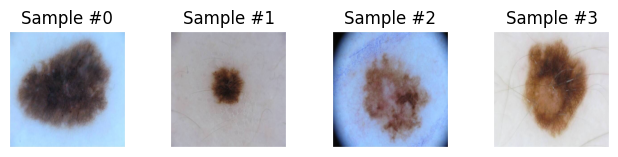

test dataset


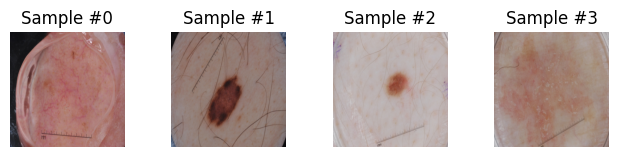

valid dataset


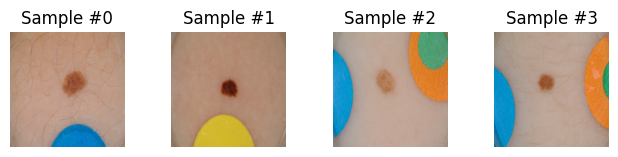


Their ground truth

train dataset


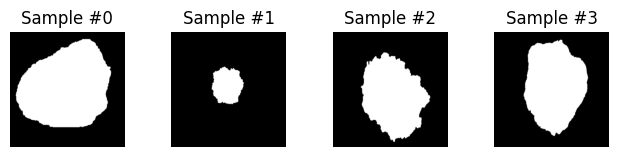

test dataset


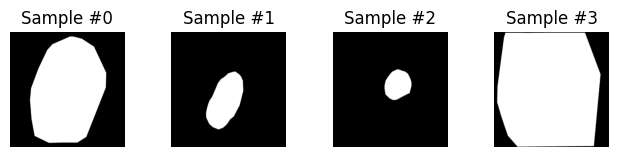

valid dataset


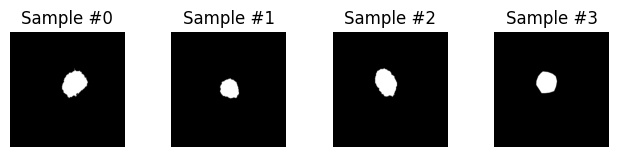

In [13]:
print("images\n")

for k, dataset in enumerate(datasets):
    print(dataset_labels[k] + " dataset")
    fig = plt.figure()
    for i in range(len(dataset)):
        sample = dataset[i]
        ax = plt.subplot(1, 4, i + 1)
        plt.tight_layout()
        ax.set_title("Sample #{}".format(i))
        ax.axis("off")
        plt.imshow(sample[0].permute(1, 2, 0))
        if i == 3:
            plt.show()
            break

print("\nTheir ground truth\n")

for k, dataset in enumerate(datasets):
    print(dataset_labels[k] + " dataset")
    fig = plt.figure()
    for i in range(len(dataset)):
        sample = dataset[i]
        ax = plt.subplot(1, 4, i + 1)
        plt.tight_layout()
        ax.set_title("Sample #{}".format(i))
        ax.axis("off")
        plt.imshow(sample[1][0], cmap="gray")
        if i == 3:
            plt.show()
            break

**creating data loaders**

In [14]:
batch_size = 8

In [15]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)

In [16]:
!nvidia-smi

Fri Mar 31 18:36:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA P106-100     Off  | 00000000:02:00.0 Off |                  N/A |
| 21%   32C    P8     4W / 120W |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


##defining the network

In [17]:
class Unet(Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.conv1 = Conv2d(3, 64, kernel_size=3, stride=1)
        self.conv2 = Conv2d(64, 64, kernel_size=3, stride=1)
        self.bnorm64 = BatchNorm2d(64)

        self.conv3 = Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv4 = Conv2d(128, 128, kernel_size=3, stride=1)
        self.bnorm128 = BatchNorm2d(128)

        self.conv5 = Conv2d(128, 256, kernel_size=3, stride=1)
        self.conv6 = Conv2d(256, 256, kernel_size=3, stride=1)
        self.bnorm256 = BatchNorm2d(256)

        self.conv7 = Conv2d(256, 512, kernel_size=3, stride=1)
        self.conv8 = Conv2d(512, 512, kernel_size=3, stride=1)
        self.bnorm512 = BatchNorm2d(512)

        # self.conv7 = Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        # self.conv8 = Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        # self.bnorm512 = BatchNorm2d(512)

        self.conv9 = Conv2d(512, 1024, kernel_size=3, stride=1)
        self.conv10 = Conv2d(1024, 1024, kernel_size=3, stride=1)
        self.bnorm1024 = BatchNorm2d(1024)

        self.upconv1 = ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv11 = Conv2d(1024, 512, kernel_size=3, stride=1)

        self.upconv2 = ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv12 = Conv2d(512, 256, kernel_size=3, stride=1)

        self.upconv3 = ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv13 = Conv2d(256, 128, kernel_size=3, stride=1)

        self.upconv4 = ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv14 = Conv2d(128, 64, kernel_size=3, stride=1)

        self.conv15 = Conv2d(64, 1, kernel_size=1, stride=1)

        self.maxpool = MaxPool2d(kernel_size=2, stride=2)
        self.relu = ReLU(inplace=True)

    def forward(self, x):
        ##downsampling
        x = self.conv1(x)
        # print(self.block1.shape)
        x = self.bnorm64(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bnorm64(x)
        x = self.relu(x)
        self.block1 = x
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bnorm128(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bnorm128(x)
        x = self.relu(x)
        self.block2 = x
        x = self.maxpool(x)

        x = self.conv5(x)
        x = self.bnorm256(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.bnorm256(x)
        x = self.relu(x)
        self.block3 = x
        x = self.maxpool(x)

        x = self.conv7(x)
        # print(x.shape)
        x = self.bnorm512(x)
        x = self.relu(x)
        x = self.conv8(x)
        # print(x.shape)
        x = self.bnorm512(x)
        x = self.relu(x)
        self.block4 = x
        x = self.maxpool(x)

        x = self.conv9(x)
        x = self.bnorm1024(x)
        x = self.relu(x)
        x = self.conv10(x)
        x = self.bnorm1024(x)
        x = self.relu(x)
        self.block5 = x

        ##upsampling
        self.catblock1 = self.crop_and_concat(
            self.upconv1(self.block5), self.block4, crop=True
        )
        self.upblock1 = self.bnorm512(
            self.relu(self.conv8(self.bnorm512(self.relu(self.conv11(self.catblock1)))))
        )

        self.catblock2 = self.crop_and_concat(
            self.upconv2(self.upblock1), self.block3, crop=True
        )
        self.upblock2 = self.bnorm256(
            self.relu(self.conv6(self.bnorm256(self.relu(self.conv12(self.catblock2)))))
        )

        self.catblock3 = self.crop_and_concat(
            self.upconv3(self.upblock2), self.block2, crop=True
        )
        self.upblock3 = self.bnorm128(
            self.relu(self.conv4(self.bnorm128(self.relu(self.conv13(self.catblock3)))))
        )

        self.catblock4 = self.crop_and_concat(
            self.upconv4(self.upblock3), self.block1, crop=True
        )
        self.upblock4 = self.bnorm64(
            self.relu(self.conv2(self.bnorm64(self.relu(self.conv14(self.catblock4)))))
        )

        self.logits = self.conv15(self.upblock4)
        return self.logits

    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

In [18]:
class IoULoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, threshold=0.5):
        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)
        # thres = torch.nn.Threshold(threshold=threshold,value=0 )
        # inputs = thres(inputs)
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        threshold = torch.tensor([0.5])
        results = torch.tensor([])
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        results, threshold = results.to(device), threshold.to(device)
        results = (inputs > threshold).float() * 1

        # print(inputs.sum())
        # intersection is equivalent to True Positive count
        # union is the mutually inclusive area of all labels & predictions
        intersection = (results * targets).sum()
        total = (results + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth) / (union + smooth)

        return 1 - IoU

In [19]:
#: Loss binary mode suppose you are solving binary segmentation task.
#: That mean yor have only one class which pixels are labled as **1**,
#: the rest pixels are background and labeled as **0**.
#: Target mask shape - (N, H, W), model output mask shape (N, 1, H, W).
BINARY_MODE: str = "binary"

#: Loss multiclass mode suppose you are solving multi-**class** segmentation task.
#: That mean you have *C = 1..N* classes which have unique label values,
#: classes are mutually exclusive and all pixels are labeled with theese values.
#: Target mask shape - (N, H, W), model output mask shape (N, C, H, W).
MULTICLASS_MODE: str = "multiclass"

#: Loss multilabel mode suppose you are solving multi-**label** segmentation task.
#: That mean you have *C = 1..N* classes which pixels are labeled as **1**,
#: classes are not mutually exclusive and each class have its own *channel*,
#: pixels in each channel which are not belong to class labeled as **0**.
#: Target mask shape - (N, C, H, W), model output mask shape (N, C, H, W).
MULTILABEL_MODE: str = "multilabel"

In [20]:
def soft_jaccard_score(
    output: torch.Tensor,
    target: torch.Tensor,
    smooth: float = 0.0,
    eps: float = 1e-7,
    dims=None,
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)

    union = cardinality - intersection
    jaccard_score = (intersection + smooth) / (union + smooth).clamp_min(eps)
    return jaccard_score

In [21]:
def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.array(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

In [22]:
from typing import Optional, List

import torch
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

__all__ = ["JaccardLoss"]


class JaccardLoss(_Loss):
    def __init__(
        self,
        mode: str,
        classes: Optional[List[int]] = None,
        log_loss: bool = False,
        from_logits: bool = True,
        smooth: float = 0.0,
        eps: float = 1e-7,
    ):
        """Jaccard loss for image segmentation task.
        It supports binary, multiclass and multilabel cases
        Args:
            mode: Loss mode 'binary', 'multiclass' or 'multilabel'
            classes:  List of classes that contribute in loss computation. By default, all channels are included.
            log_loss: If True, loss computed as `- log(jaccard_coeff)`, otherwise `1 - jaccard_coeff`
            from_logits: If True, assumes input is raw logits
            smooth: Smoothness constant for dice coefficient
            eps: A small epsilon for numerical stability to avoid zero division error
                (denominator will be always greater or equal to eps)
        Shape
             - **y_pred** - torch.Tensor of shape (N, C, H, W)
             - **y_true** - torch.Tensor of shape (N, H, W) or (N, C, H, W)
        Reference
            https://github.com/BloodAxe/pytorch-toolbelt
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(JaccardLoss, self).__init__()

        self.mode = mode
        if classes is not None:
            assert (
                mode != BINARY_MODE
            ), "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
            y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

        scores = soft_jaccard_score(
            y_pred,
            y_true.type(y_pred.dtype),
            smooth=self.smooth,
            eps=self.eps,
            dims=dims,
        )

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # IoU loss is defined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.float()

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np


def compute_iou(y_pred, y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [24]:
def iou_per_volume(validation_pred, validation_true, patient_slice_index):
    iou_list = []
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0

    for p in range(len(num_slices)):
        y_pred = np.array(validation_pred[index : index + num_slices[p]])
        y_true = np.array(validation_true[index : index + num_slices[p]])
        iou_list.append(dsc(y_pred, y_true))
        index += num_slices[p]
    return iou_list

In [25]:
checkpoints_path = "/content/gdrive/MyDrive/data/unet_isic_checkpoints/"

In [26]:

#hyper_params = {
#    "input_size": 572,
#    "num_layers": 2,
#    "num_classes": 1,
#    "batch_size": 8,
#    "num_epochs": 100,
#    "learning_rate": 0.00001
#}

hyper_params = {
    "input_size": 572,
    "num_layers": 2,
    "num_classes": 1,
    "batch_size": 2,
    "num_epochs": 1,
    "learning_rate": 0.00001
}


experiment = Experiment(
    api_key="uespiI7sf0P5L5g2ja4vTFz25",
    project_name="unet-isic",
    workspace="omarkhaled99",
)

torch.cuda.empty_cache()
# experiment = Experiment(project_name="unet-isic-pytorch")
experiment.log_parameters(hyper_params)

lr = hyper_params["learning_rate"]
epochs = hyper_params["num_epochs"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = Unet()
unet.to(device)
iou_loss = JaccardLoss(BINARY_MODE)
best_validation_iou = 0.0
optimizer = Adam(unet.parameters(), lr=lr)

loss_train = []
loss_valid = []

loaders = {"train": train_dataloader, "valid": valid_dataloader}
validation_iou = []
train_iou =  []
step = 0
!nvidia-smi
for epoch in tqdm(range(epochs), total=epochs):
    for phase in ["train", "valid"]:
        if phase == "train":
            unet.train()
        else:
            unet.eval()

        validation_pred = []
        validation_true = []

        for i, data in enumerate(loaders[phase]):
            if phase == "train":
                step += 1
            x, y_true = data
            print(x.shape,y_true.shape)

            x, y_true = x.to(device), y_true.to(device)
       
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                # if phase == "valid":
                #   torch.no_grad() 
                y_pred = unet(x)
                loss = iou_loss(y_pred, y_true)

                if phase == "valid":
                    loss_valid.append(loss.item())
                    validation_iou.append(compute_iou(y_pred.cpu()>=0.5,y_true.cpu()>=0.5))
                    experiment.log_image(image_data= y_pred.detach().cpu()[0][0],name = str(epoch)+"_"+str(i))
                    experiment.log_image(image_data= y_true.detach().cpu()[0][0],name = str(epoch)+"_"+str(i))
                    # print(validation_iou)
                if phase == "train":
                    loss_train.append(loss.item())
                    experiment.log_metric("train_loss",loss.item(), step=step, epoch=epoch)
                    train_iou.append(compute_iou(y_pred.cpu()>=0.5,y_true.cpu()>=0.5))
                    loss.backward()
                    optimizer.step()

            if phase == "train" and (step) % 10 == 0:
                print('training loss for step {} is {}'.format(step,loss_train[-1]))
                print('training iou for step {} is {}'.format(step,train_iou[-1]))
                loss_train = []

        if phase == "valid":
            print('valid loss for epoch {} is {}'.format(epoch,np.mean(loss_valid)))
            experiment.log_metric("val_loss",np.mean(loss_valid), step=step, epoch=epoch)

            mean_iou = np.mean(validation_iou)
            print('val_iou {} for epoch {}'.format(mean_iou, epoch))
            experiment.log_metric("valid_iou",mean_iou, epoch=epoch)
            experiment.log_metric("train_iou",np.mean(train_iou), epoch=epoch)
            validation_iou = []
            train_iou =  []
            if (mean_iou > best_validation_iou) or (epoch%10 == 0):
                best_validation_iou = mean_iou
                torch.save(unet.state_dict(), os.path.join(checkpoints_path, "unet-epoch-"+str(epoch)+".pt"))
            loss_valid = []

print("Best validation mean IOU: {:4f}".format(best_validation_iou))
# experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/shan/Spaces/Personal/Skin' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/omarkhaled99/unet-isic/b434532f927c4efc89b6e8502deea298



Fri Mar 31 18:36:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA P106-100     Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   33C    P0    24W / 120W |    542MiB /  6144MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([8, 3, 572, 572]) torch.Size([8, 1, 388, 388])


OutOfMemoryError: CUDA out of memory. Tried to allocate 70.00 MiB (GPU 0; 5.93 GiB total capacity; 5.18 GiB already allocated; 26.69 MiB free; 5.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.save(
    unet.state_dict(),
    os.path.join(checkpoints_path, "unet-epoch-19-jaccard-loss-class.pt"),
)

In [ ]:
experiment.end()

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/omarkhaled99/unet-isic/33e9d3ae75f94856a614aaca1ef7764a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [336]        : (0.5652216672897339, 0.9480596780776978)
COMET INFO:     train_iou [13]    : (0.4099361062216828, 0.49664237142320555)
COMET INFO:     train_loss [3364] : (0.37329477071762085, 0.9480596780776978)
COMET INFO:     valid_iou         : 0.4134222270274075
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1FctT7psRKYKI31bFycug3WdstBxEFlii
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 8
COMET INFO:     input_size    : 572
COMET INFO:     learning_rate : 1e-05
COMET INFO:     num_classes   : 1
COM

In [ ]:
out = unet(test_dataset[58][0].to(device).unsqueeze(0)).detach().cpu()

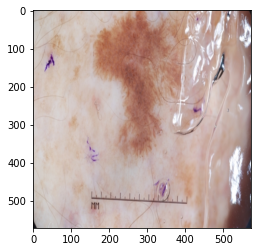

In [ ]:
plt.imshow(test_dataset[58][0].permute(1, 2, 0))

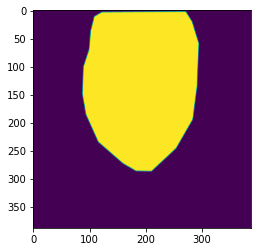

In [ ]:
plt.imshow(test_dataset[58][1][0])

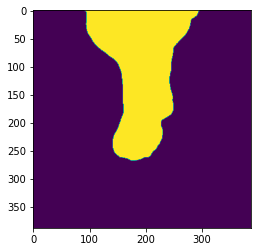

In [ ]:
plt.imshow(out[0][0] >= 0.5)

In [ ]:
compute_iou(test_dataset[10][1][0] >= 0.5, out[0][0] >= 0.5)

0.5758615320842213

In [ ]:
test_losses = []
test_loss = 0.0
test_ious = []
test_iou = 0.0
for i, data in enumerate(test_dataloader):
    x, y_true = data
    x, y_true = x.to(device), y_true.to(device)

    with torch.no_grad():
        y_pred = unet(x)
        loss = iou_loss(y_pred, y_true)
        test_losses.append(loss.item())
        test_ious.append(compute_iou(y_pred.cpu() >= 0.5, y_true.cpu() >= 0.5))

test_loss = np.mean(test_losses)
test_iou = np.mean(test_ious)
print(test_loss)
print(test_iou)

0.5917617877324423
0.6089366274663401
